In [1]:
import numpy as np
from scipy.stats import norm, invgamma, t
import matplotlib.pyplot as plt

In [2]:
# generate training data

n_data = 2000

normal_noise = norm()

x_data = np.linspace(-3, 3, n_data)

y_data = 1.2 * np.sin(x_data) + 0.2 * np.sin(5*np.exp(x_data)) + norm.rvs(scale=0.05**2, size=n_data)

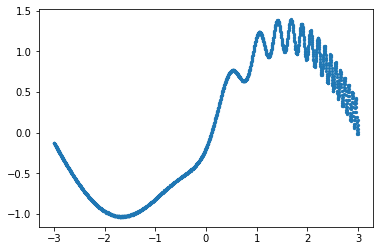

In [3]:
# plot experiment data

marker_size = 5

plt.scatter(x_data, y_data, s=marker_size)

In [4]:
# generate BLR model from data

x_features = np.sin(x_data)

n_dimensions = 1

weights_init = np.zeros(n_dimensions) #w_0
a_param_init = 0 #a_0
b_param_init = 0 #b_0
param_variance_init = 999999999999999999999 #tau_0
variance_init = 1000000000 #sigma_0
params_covariance_init = param_variance_init / variance_init * np.eye(n_dimensions)
inv_params_covariance_init = np.linalg.inv(params_covariance_init)
# print(inv_params_covariance_init)

inv_params_covariance = inv_params_covariance_init + x_features.T@x_features
params_covariance = np.linalg.inv(inv_params_covariance)
weights = params_covariance @ (inv_params_covariance_init @ weights_init + x_features.T @ y_data)
a_param_n = a_param_init + n_data / 2
b_param_n = b_param_init + 0.5 * (weights_init.T@inv_params_covariance_init@weights_init + y_data.T@y_data - weights.T @ inv_params_covariance @ weights)

print(a_param_n)
print(b_param_n)
print(weights[0])
print(x_features.T@x_features)
print(inv_params_covariance)
print(params_covariance[0,0])

1000.0
16.14096407036709
1.1211756728634745
1046.0657401539243
[[1046.06574015]]
0.0009559628631493593


In [12]:
# Try the same using BLR class
import sys
sys.path.append('../')
from models.learning.blr_slip import SlipBayesianLinearRegression

slip_input_dimensions = 1
a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000

slip_blr = SlipBayesianLinearRegression(slip_input_dimensions, a_param_init, b_param_init, param_variance_init, variance_init)

slip_blr.train_params(x_features, y_data)

test_blr_slip_ang_mean, test_blr_slip_ang_variance = slip_blr.predict(x_features)

print(slip_blr.a_param_n)
print(slip_blr.b_param_n)
print(slip_blr.weights)
print(slip_blr.params_covariance)


print(test_blr_slip_ang_mean)
print(np.sqrt(np.diag(test_blr_slip_ang_variance)))

1000.0
[[16.14096407]]
[[1.12117567]]
[[0.00095596]]
[[-0.15822032]
 [-0.16155113]
 [-0.16488049]
 ...
 [ 0.16488049]
 [ 0.16155113]
 [ 0.15822032]]
[0.12711188 0.12711193 0.12711198 ... 0.12711198 0.12711193 0.12711188]


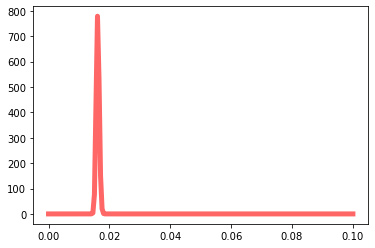

In [6]:
# initialize distributions for sigma

sigma_a = a_param_n
sigma_b = b_param_n

sigma_distribution = invgamma(a_param_n, scale = b_param_n)

# weights_distribution = norm()

a = 1.2

# x = np.linspace(sigma_distribution.ppf(0.01, sigma_a), sigma_distribution.ppf(0.99, sigma_a), 100)

x = np.linspace(0, 0.1, 200)

plt.plot(x, sigma_distribution.pdf(x),'r-', lw=5, alpha=0.6, label='invgamma pdf')

0.0039281245177182275


/home/dominic/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
/home/dominic/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in multiply
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


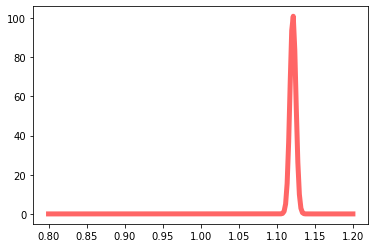

In [16]:
# initialize distribution for weights

df = 2 * a_param_n
loc_t = weights[0]
scale_t = np.sqrt((b_param_n / a_param_n) * params_covariance[0,0])
print(scale_t)

# weights_distribution = t()

x = np.linspace(0.8, 1.2, 200)

plt.plot(x, t.pdf(x, df, loc=loc_t, scale=scale_t),'r-', lw=5, alpha=0.6, label='t pdf')


In [18]:
# compute mean and variance of predictions

# y_prediction_mean = loc_t * x_features 
# y_prediction_sigma = np.sqrt(invgamma.mean(a_param_n, scale = b_param_n))
y_prediction_sigma = np.sqrt(x_features**2 * scale_t**2) + np.sqrt(b_param_n / (a_param_n + 1)) #np.sqrt(invgamma.mean(a_param_n, scale = b_param_n))
variance_param = np.sqrt(b_param_n / a_param_n * (x_data.reshape(2000, 1) @ params_covariance @ x_data.reshape(1, 2000)))

print(np.sqrt(np.diag(test_blr_slip_ang_variance)))
print(y_prediction_sigma)
print(variance_param)

[0.12711188 0.12711193 0.12711198 ... 0.12711198 0.12711193 0.12711188]
[0.12753795 0.12754962 0.12756129 ... 0.12756129 0.12754962 0.12753795]
[[0.01178437 0.01177848 0.01177258 ...        nan        nan        nan]
 [0.01177848 0.01177258 0.01176669 ...        nan        nan        nan]
 [0.01177258 0.01176669 0.01176079 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ... 0.01176079 0.01176669 0.01177258]
 [       nan        nan        nan ... 0.01176669 0.01177258 0.01177848]
 [       nan        nan        nan ... 0.01177258 0.01177848 0.01178437]]


/tmp/ipykernel_52896/1755571978.py:6: RuntimeWarning: invalid value encountered in sqrt
  variance_param = np.sqrt(b_param_n / a_param_n * (x_data.reshape(2000, 1) @ params_covariance @ x_data.reshape(1, 2000)))


/tmp/ipykernel_52896/3684220374.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(x_data, test_blr_slip_ang_mean[:, 0] - 2 * np.diag(np.sqrt(test_blr_slip_ang_variance)),
/tmp/ipykernel_52896/3684220374.py:9: RuntimeWarning: invalid value encountered in sqrt
  test_blr_slip_ang_mean[:, 0] + 2 * np.diag(np.sqrt(test_blr_slip_ang_variance)), color='C1', alpha = 0.2, label='predicted variance')


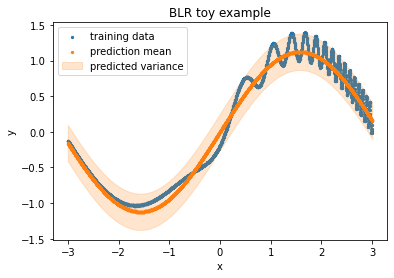

In [20]:
# plot fit data

marker_size = 5

plt.scatter(x_data, y_data, s=marker_size, label='training data')
plt.scatter(x_data, test_blr_slip_ang_mean, s=marker_size, label='prediction mean')

plt.fill_between(x_data, test_blr_slip_ang_mean[:, 0] - 2 * np.diag(np.sqrt(test_blr_slip_ang_variance)), 
                 test_blr_slip_ang_mean[:, 0] + 2 * np.diag(np.sqrt(test_blr_slip_ang_variance)), color='C1', alpha = 0.2, label='predicted variance')

plt.title('BLR toy example')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()